# Configurations

In [1]:
import os
import torch
import lightning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Any, Optional, Tuple

from mlcolvar.cvs import BaseCV,VariationalAutoEncoderCV
from mlcolvar.core.loss.mse import mse_loss
from mlcolvar.core import FeedForward, Normalization
from mlcolvar.core.transform.utils import Inverse
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))


torch.manual_seed(41)

In [3]:
# Datasets

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR",
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]
n_states = len(filenames)

dataset, df = create_dataset_from_files(
	filenames,
	filter_args={'regex':'d_' }, # select distances between heavy atoms
	create_labels=True,
	return_dataframe=True,
)

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

In [5]:
# Beta VAE

class ELBOGaussiansLossBeta(torch.nn.Module):
    def forward(
        self,
        target: torch.Tensor,
        output: torch.Tensor,
        mean: torch.Tensor,
        log_variance: torch.Tensor,
        weights: Optional[torch.Tensor] = None,
        beta: float = 4.0,
    ) -> torch.Tensor:
        return elbo_gaussians_loss_beta(target, output, mean, log_variance, weights, beta)

def elbo_gaussians_loss_beta(
    target: torch.Tensor,
    output: torch.Tensor,
    mean: torch.Tensor,
    log_variance: torch.Tensor,
    weights: Optional[torch.Tensor] = None,
    beta: float = 4.0,
) -> torch.Tensor:
    kl = -0.5 * (log_variance - log_variance.exp() - mean**2 + 1).sum(dim=1)

    # Weighted mean over batches.
    if weights is None:
        kl = kl.mean()
    else:
        weights = weights.squeeze()
        if weights.shape != kl.shape:
            raise ValueError(
                f"weights should be a tensor of shape (n_batches,) or (n_batches,1), not {weights.shape}."
            )
        kl = (kl * weights).sum()

    # Reconstruction loss.
    reconstruction = mse_loss(output, target, weights=weights)

    return reconstruction, beta * kl

class VariationalAutoEncoderCVBeta(BaseCV, lightning.LightningModule):
	BLOCKS = ["norm_in", "encoder", "decoder"]
	def __init__(
		self,
		n_cvs: int,
		encoder_layers: list,
		decoder_layers: Optional[list] = None,
		options: Optional[dict] = None,
		**kwargs,
	):
		super().__init__(in_features=encoder_layers[0], out_features=n_cvs, **kwargs)

		# =======   LOSS  =======
		# ELBO loss function when latent space and reconstruction distributions are Gaussians.
		self.loss_fn = ELBOGaussiansLossBeta()

		# ======= OPTIONS =======
		# parse and sanitize
		options = self.parse_options(options)

		# if decoder is not given reverse the encoder
		if decoder_layers is None:
			decoder_layers = encoder_layers[::-1]

		# ======= BLOCKS =======

		# initialize norm_in
		o = "norm_in"
		if (options[o] is not False) and (options[o] is not None):
			self.norm_in = Normalization(self.in_features, **options[o])

		# initialize encoder
		o = "encoder"
		if "last_layer_activation" not in options[o]:
			options[o]["last_layer_activation"] = True

		self.encoder = FeedForward(encoder_layers, **options[o])
		self.mean_nn = torch.nn.Linear(
			in_features=encoder_layers[-1], out_features=n_cvs
		)
		self.log_var_nn = torch.nn.Linear(
			in_features=encoder_layers[-1], out_features=n_cvs
		)

		# initialize encoder
		o = "decoder"
		self.decoder = FeedForward([n_cvs] + decoder_layers, **options[o])
		
	def training_step(self, train_batch, batch_idx):
		x = train_batch["data"]
		loss_kwargs = {}
		if "weights" in train_batch:
			loss_kwargs["weights"] = train_batch["weights"]

		mean, log_variance, x_hat = self.encode_decode(x)

		if "target" in train_batch:
			x_ref = train_batch["target"]
		else:
			x_ref = x

		recon, regular = self.loss_fn(x_ref, x_hat, mean, log_variance, **loss_kwargs)
		loss = recon + regular
		name = "train" if self.training else "valid"
		self.log(f"{name}_loss", loss, prog_bar=True, on_epoch=True)
		self.log(f"{name}_recon", recon, prog_bar=True, on_epoch=True)
		self.log(f"{name}_regul", regular, prog_bar=True, on_epoch=True)

		return loss


	def forward_cv(self, x: torch.Tensor) -> torch.Tensor:
		if self.norm_in is not None:
			x = self.norm_in(x)
		x = self.encoder(x)

		# Take only the means and ignore the log variances.
		return self.mean_nn(x)

	def encode_decode(
		self, x: torch.Tensor
	) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
		# Normalize inputs.
		if self.norm_in is not None:
			x = self.norm_in(x)

		# Encode input into a Gaussian distribution.
		x = self.encoder(x)
		mean, log_variance = self.mean_nn(x), self.log_var_nn(x)

		# Sample from the Gaussian distribution in latent space.
		std = torch.exp(log_variance / 2)
		z = torch.distributions.Normal(mean, std).rsample()

		# Decode sample.
		x_hat = self.decoder(z)
		if self.norm_in is not None:
			x_hat = self.norm_in.inverse(x_hat)

		return mean, log_variance, x_hat

	def get_decoder(self, return_normalization=False):
		"""Return a torch model with the decoder and optionally the normalization inverse"""
		if return_normalization:
			if self.norm_in is not None:
				inv_norm = Inverse(module=self.norm_in)
				decoder_model = torch.nn.Sequential(*[self.decoder, inv_norm])
			else:
				raise ValueError(
					"return_normalization is set to True but self.norm_in is None"
				)
		else:
			decoder_model = self.decoder
		return decoder_model

# Load model

In [6]:

# Set model
n_components = 1
encoder_layers = [45, 128, 128, n_components]
decoder_layers = [128, 128, 45]
nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = VariationalAutoEncoderCV(
    n_cvs = n_components,
    encoder_layers = encoder_layers,
    decoder_layers = decoder_layers,
    options=options
)

# Load model
# version = "v1"
# checkpoint_file = torch.load(f'./vaecv-{version}.pt')
# model.load_state_dict(checkpoint_file)
# model.eval()

In [24]:
options

{'encoder': {'activation': 'shifted_softplus', 'last_layer_activation': True},
 'decoder': {'activation': 'shifted_softplus', 'last_layer_activation': True},
 'norm_in': {}}

In [23]:

# Set model
n_components = 1
encoder_layers = [45, 128, 128, n_components]
decoder_layers = [128, 128, 45]
nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = VariationalAutoEncoderCVBeta(
    n_cvs = n_components,
    encoder_layers = encoder_layers,
    decoder_layers = decoder_layers,
    options=options
)
model

# Load model
version = "v2"
checkpoint_file = torch.load(f'./vaecv-beta-{version}.pt')
model.load_state_dict(checkpoint_file)
model.eval()

VariationalAutoEncoderCVBeta(
  (loss_fn): ELBOGaussiansLossBeta()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=128, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=128, out_features=1, bias=True)
      (5): Shifted_Softplus(beta=1, threshold=20)
    )
  )
  (mean_nn): Linear(in_features=1, out_features=1, bias=True)
  (log_var_nn): Linear(in_features=1, out_features=1, bias=True)
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=128, out_features=45, bias=Tru

# Visualization

In [11]:
X = dataset[:]['data']
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i]

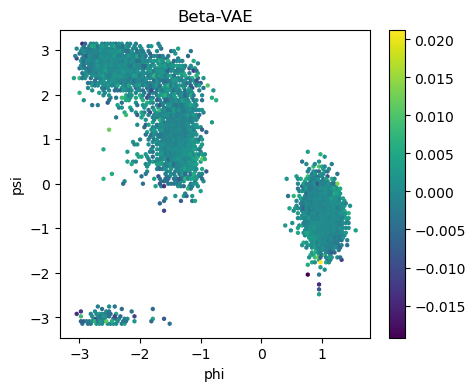

In [22]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax)
    ax.set_title(f'Beta-VAE')

In [13]:
max_cv0 = df['CV0'].max()
min_cv0 = df['CV0'].min()
boundary = np.linspace(min_cv0, max_cv0, 10)
boundary

array([-0.01923937, -0.0147366 , -0.01023383, -0.00573107, -0.0012283 ,
        0.00327447,  0.00777723,  0.01228   ,  0.01678277,  0.02128553])

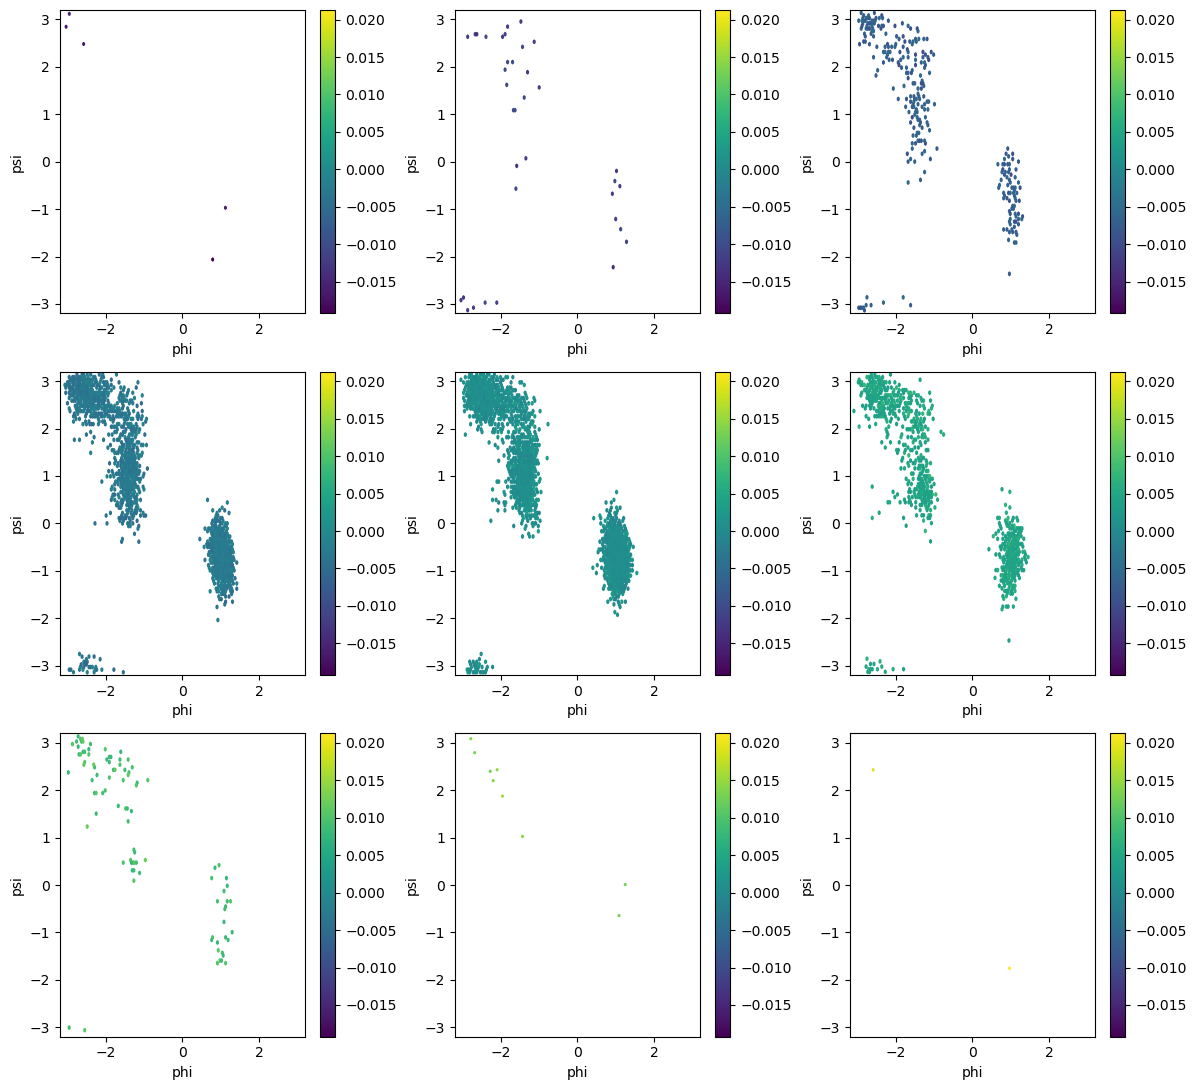

In [14]:
fig,axs = plt.subplots(3, 3, figsize = ( 12, 11 ) )
axs = axs.ravel()

for i in range(0, min(len(boundary)-1, 9)):
	ax = axs[i]
	df_selected = df[(df[f'CV0'] <= boundary[i+1]) & (df[f'CV0'] >= boundary[i])]
	if len(df_selected) == 0:
		continue
	df_selected.plot.hexbin(
		'phi', 'psi', C=f'CV0',
  		vmin=boundary[0], vmax=boundary[-1],
    	cmap='viridis', ax=ax
    )
	# ax.set_title(f'CV value in [{boundary[i]:.2f},{boundary[i+1]:.2f}]')
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
plt.tight_layout()

## More data points

In [15]:
more_data = torch.load("../../../data/alanine/heavy_atom_distance.pt")
more_data.shape

torch.Size([1000000, 45])

In [16]:
with torch.no_grad():
    s = model(more_data).numpy()
    
new_df = pd.DataFrame(s, columns=[f'CV{i}' for i in range(n_components)])
new_df

,CV0
0,0.000058
1,-0.000136
2,-0.000034
3,0.000018
4,-0.000932
...,...
999995,-0.017514
999996,-0.031795
999997,0.009143
999998,-0.026302


In [17]:
psis = np.load("../../../data/alanine/heavy_atom_distance_psis.npy")
phis = np.load("../../../data/alanine/heavy_atom_distance_phis.npy")
new_df['psi'] = psis
new_df['phi'] = phis
new_df

,CV0,psi,phi
0,0.000058,2.724753,-2.496995
1,-0.000136,2.714459,-2.490017
2,-0.000034,2.701140,-2.479672
3,0.000018,2.702199,-2.466322
4,-0.000932,2.717623,-2.420580
...,...,...,...
999995,-0.017514,2.619246,-1.407471
999996,-0.031795,2.730429,-1.359652
999997,0.009143,2.644886,-1.330804
999998,-0.026302,2.551387,-1.297497


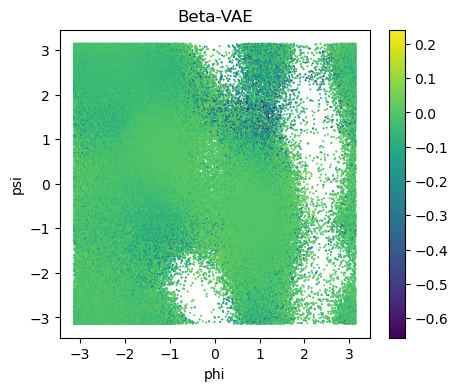

In [21]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    new_df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax, gridsize=400)
    ax.set_title(f'Beta-VAE')

In [19]:
max_cv0 = new_df['CV0'].max()
min_cv0 = new_df['CV0'].min()
boundary = np.linspace(min_cv0, max_cv0, 10)
boundary

array([-0.72640693, -0.58149946, -0.436592  , -0.29168453, -0.14677706,
       -0.00186959,  0.14303788,  0.28794534,  0.43285281,  0.57776028])

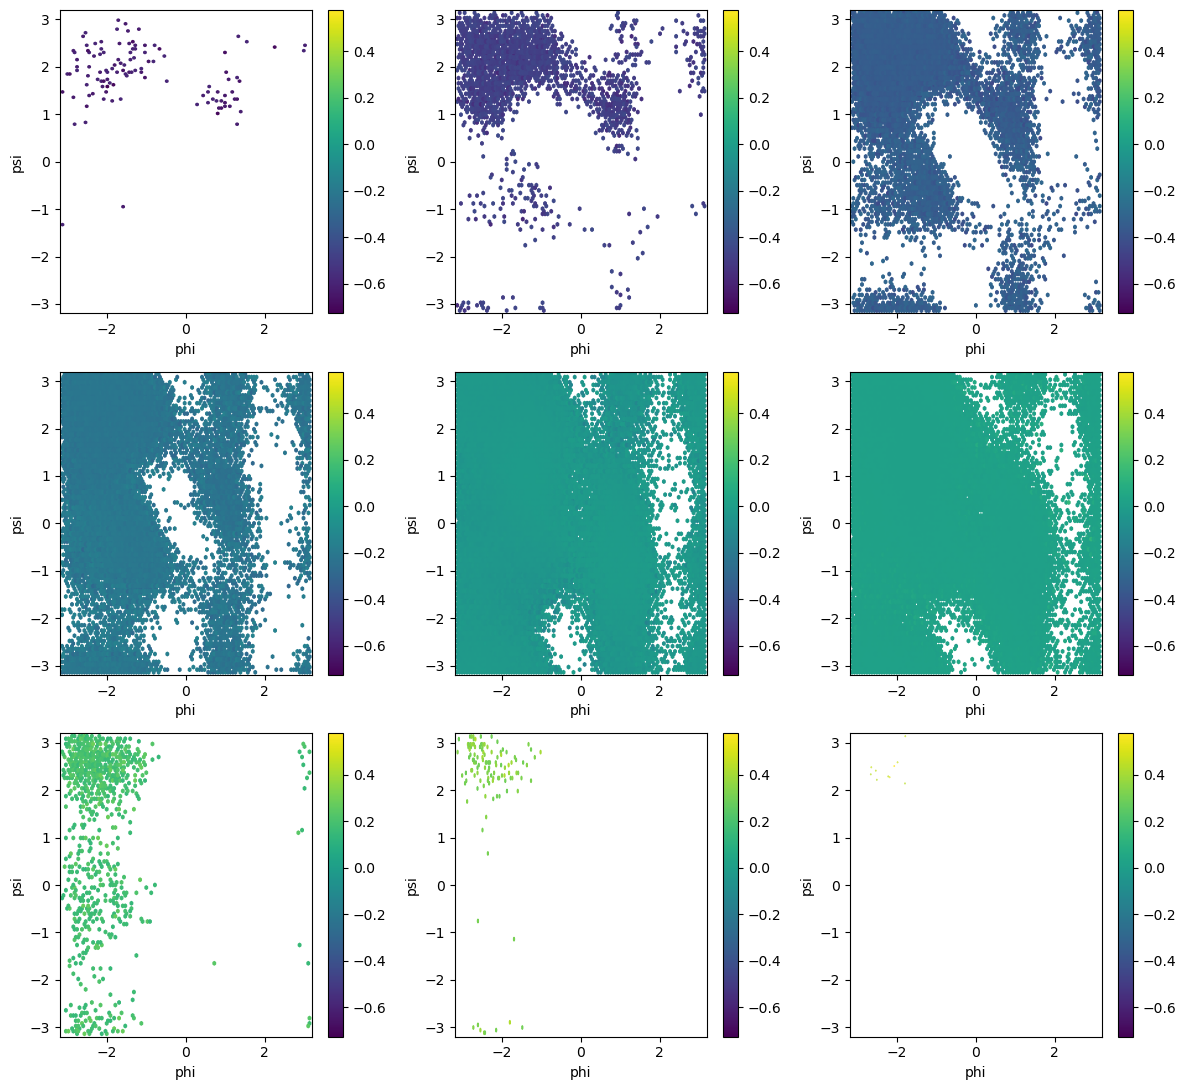

In [20]:
fig,axs = plt.subplots(3, 3, figsize = ( 12, 11 ) )
axs = axs.ravel()

for i in range(0, min(len(boundary)-1, 9)):
	ax = axs[i]
	new_df_selected = new_df[(new_df[f'CV0'] <= boundary[i+1]) & (new_df[f'CV0'] >= boundary[i])]
	if len(new_df_selected) == 0:
		continue
	new_df_selected.plot.hexbin(
		'phi', 'psi', C=f'CV0',
  		vmin=boundary[0], vmax=boundary[-1],
    	cmap='viridis', ax=ax
    )
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
plt.tight_layout()